In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
# Add functions path
sys.path.append('../Functions')

In [2]:
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset.csv', labels='category', samples_per_label=1000)

In [3]:
# TfidfVectorizer generates bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_tf: use logarithmic form for frequency
# min_df: minimum numbers of documents a word must be present to keep it
# ngram_range: number of ngrams to use
# stopwords: remove all common pronouns in given language

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()

labels = df.category

print('{} samples represented by {} features'.format(features.shape[0], features.shape[1]))

7000 samples represented by 42076 features


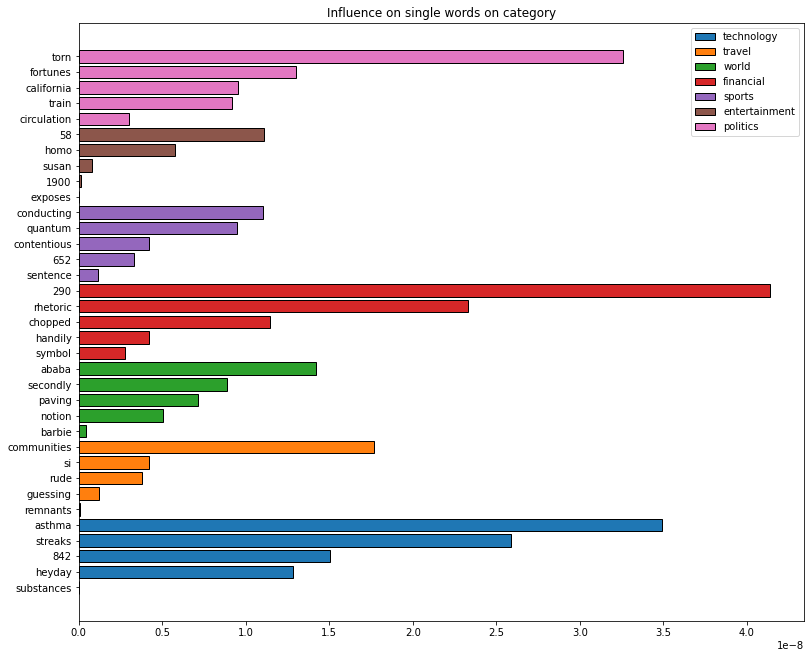

In [4]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2

fig = plt.figure(figsize=(13,11))
ax = plt.subplot(111)

for category in df.category.unique():
    features_chi2 = chi2(features, labels == category)
    indices = np.argsort(features_chi2[0])
    values = np.sort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigram_mask = (np.array([len(i.split(' ')) for i in feature_names]) == 1)
    bigram_mask = (np.array([len(i.split(' ')) for i in feature_names]) == 2)
    unigrams = feature_names[unigram_mask]
    bigrams = feature_names[bigram_mask]
    unigram_values = values[unigram_mask]
    bigram_values = values[bigram_mask]
    ax.barh(unigrams[:5], unigram_values[:5], edgecolor='black', label=category)

ax.set_title('Influence on single words on category');   
plt.legend();